In [28]:
import pandas as pd
import prophet
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import IsolationForest

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



pd.options.plotting.backend = "plotly"

In [29]:
df = pd.read_csv("Data/Edu_TS_all.csv", sep=";", index_col=0,
                   parse_dates=True)

po = pd.DataFrame(df['Paid Orders'])
iforest = IsolationForest(n_estimators = 100).fit(pd.DataFrame(df['Paid Orders']))

In [30]:
iforest.score_samples(pd.DataFrame(df['Paid Orders']))

array([-0.56736713, -0.5736306 , -0.56302565, -0.56123486, -0.60468873,
       -0.53790982, -0.71184585, -0.57145815, -0.61033174, -0.55618877,
       -0.59762246, -0.55052221, -0.67286308, -0.53911673, -0.57698124,
       -0.55418582, -0.54987607, -0.57154141, -0.54671428, -0.55918377,
       -0.5684406 , -0.54711324, -0.50052084, -0.52758037, -0.4708322 ,
       -0.4425126 , -0.45466677, -0.45679021, -0.4383442 , -0.49155804,
       -0.46636784, -0.45953419, -0.51023719, -0.43879915, -0.47153517,
       -0.45407662, -0.45690743, -0.4332789 , -0.46538698, -0.4412411 ,
       -0.47474086, -0.48790457, -0.47729243, -0.49279846, -0.44242575,
       -0.47586168, -0.455449  , -0.44038813, -0.43906133, -0.44218885,
       -0.46116576, -0.45836524, -0.45192651, -0.47482389, -0.55155262,
       -0.53925103, -0.45448841, -0.47302161, -0.47874168, -0.4332789 ,
       -0.46122425, -0.44218885, -0.47474086, -0.43654956, -0.47482389,
       -0.52081834, -0.47616008, -0.54677057, -0.50235742, -0.47

In [31]:
po = po.reset_index()
po.rename(columns={'Date':'ds', 'Paid Orders':'y'}, inplace=True)
po['ds'] = pd.to_datetime(po['ds'], dayfirst=True, utc=True)
po['ds'] = po['ds'].dt.strftime("%m.%d.%Y")

01:54:16 - cmdstanpy - INFO - Chain [1] start processing


01:54:16 - cmdstanpy - INFO - Chain [1] done processing


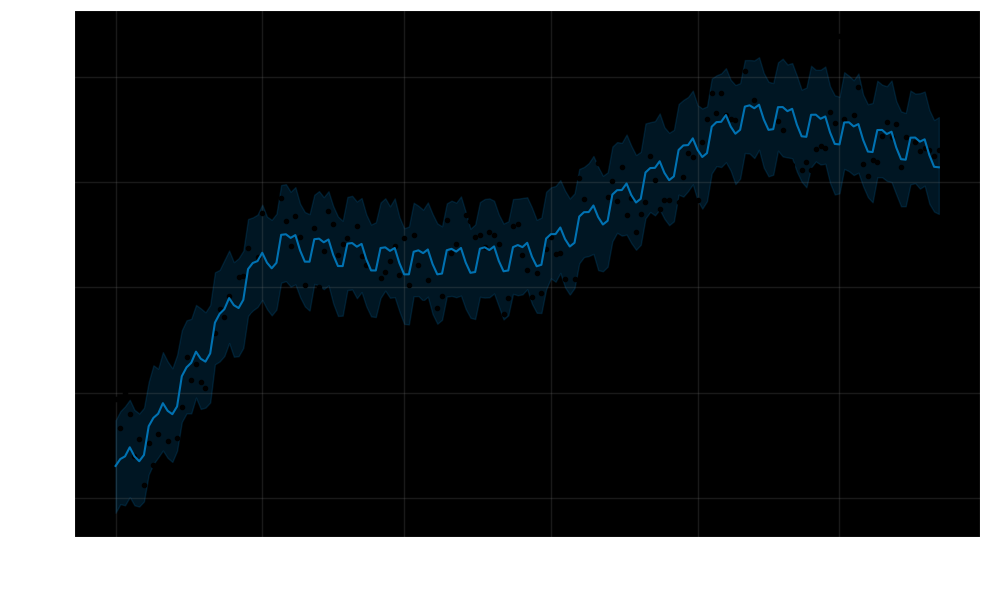

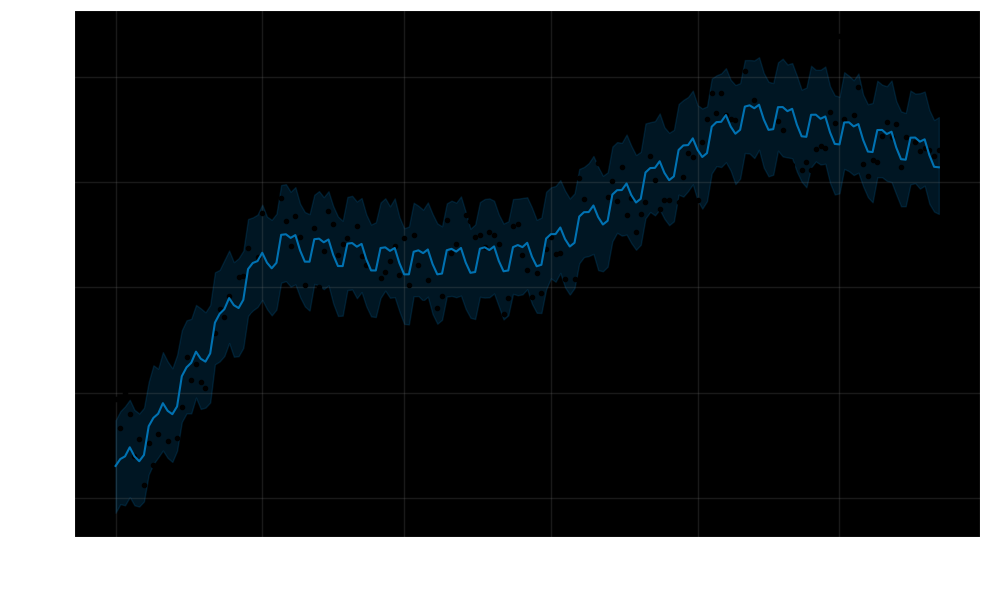

In [66]:
model = prophet.Prophet(changepoint_range=1, changepoint_prior_scale=0.25)
model.fit(po)
forecast = model.predict(po)
model.plot(forecast)

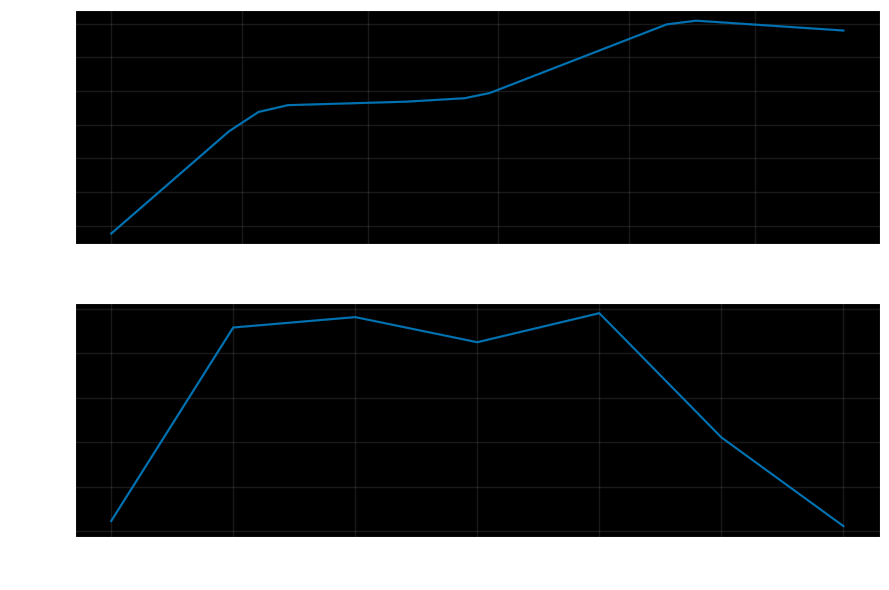

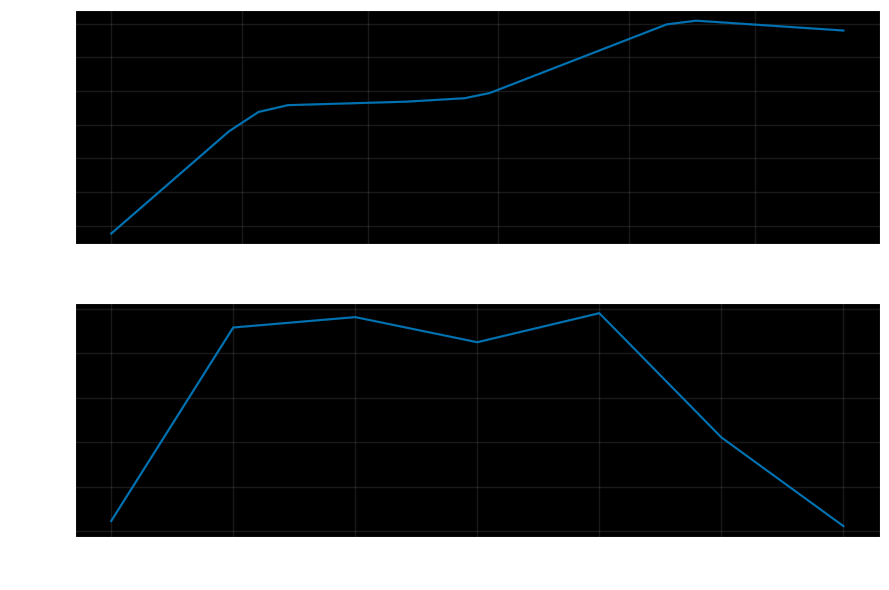

In [55]:
model.plot_components(forecast)

In [67]:
forecast_df = forecast[['ds','yhat','yhat_upper','yhat_lower']]
forecast_df['ds'] = forecast_df['ds'].dt.strftime("%m.%d.%Y")
forecast_df

/var/folders/qf/wr_f6ft15x93_rzk866s88340000gn/T/ipykernel_31323/1715788404.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,yhat,yhat_upper,yhat_lower
0,05.01.2023,460.755672,547.204884,371.813564
1,05.02.2023,473.829009,564.564484,388.260719
2,05.03.2023,478.902662,574.023770,386.059195
3,05.04.2023,496.175784,586.434082,401.690243
4,05.05.2023,478.930368,567.291568,385.921794
...,...,...,...,...
170,10.18.2023,1076.489705,1168.362461,987.224567
171,10.19.2023,1080.919904,1171.646929,992.956967
172,10.20.2023,1050.831565,1136.708445,958.410102
173,10.21.2023,1028.742907,1117.436814,943.643859


In [68]:
#Merging two dataset to have the actual and prediction values
forecasting_final = pd.merge(forecast_df, po, how='inner',
                                     left_on = 'ds', right_on = 'ds')
forecasting_final['ds'] = pd.to_datetime(forecasting_final['ds'])

# We calculate the prediction error here and uncertainty 
forecasting_final['error'] = forecasting_final['y'] - forecasting_final['yhat']
forecasting_final['uncertainty'] = forecasting_final['yhat_upper'] - forecasting_final['yhat_lower']

# We this factor we can identify the outlier or anomaly. 
# This factor can be customized based on the data
factor = 1.5
forecasting_final['anomaly'] = forecasting_final.apply(lambda x: 'Yes' 
      if(np.abs(x['error']) >  factor*x['uncertainty']) else 'No', axis = 1)

In [69]:
color_discrete_map = {'Yes': 'rgb(255,12,0)', 'No': 'blue'}
fig = px.scatter(forecasting_final, x='ds', y='y', color='anomaly', title='Anomaly',
                 color_discrete_map=color_discrete_map, trendline="lowess",
                   trendline_options=dict(frac=0.1))
fig.show()

In [70]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 56.77
Median Absolute Error (MedAE): 45.85
Mean Squared Error (MSE): 4962.19
Root Mean Squared Error (RMSE): 70.44
Mean Absolute Percentage Error (MAPE): 0.07 %
